# Tutorial 


In this tutorial, we will demonstrate how to use FinerCAM step by step.  



First, lets prepare our model

In [97]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
from pytorch_grad_cam import GradCAM,LayerCAM,ScoreCAM,GradCAMPlusPlus,XGradCAM,RandomCAM,FinerCAM
import open_clip
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

In [80]:
class ModifiedCLIP(nn.Module):
    """
    A wrapper around the original CLIP model that adds a classifier layer.
    This class initializes a linear layer for classification and loads its weights.
    """
    def __init__(self, original_model, classifier_path, num_classes):
        super(ModifiedCLIP, self).__init__()
        self.original_model = original_model
        self.classifier = nn.Linear(512, num_classes)
        self.classifier.load_state_dict(
            torch.load(classifier_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        )
        self.visual = self.original_model.visual

    def forward(self, x):
        image_features = self.original_model.encode_image(x)
        logits = self.classifier(image_features)
        return logits

In [ ]:
original_model, _, _ = open_clip.create_model_and_transforms('ViT-B-16', pretrained='laion400m_e32')
num_classes = 525
model = ModifiedCLIP(original_model, 'classifier_weight/classifier_birds_CLIP.pth', num_classes)
model.visual.pool_type = 'avg'
model = model.to('cuda')

 Bring the channels to the first dimension, like in CNNs.

In [82]:
def reshape_transform(tensor, height=16, width=16):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

Ensuring image's dimensions align with the patch size.

In [83]:
def preprocess(image, patch_size=16, max_size=1000):
    image = image.convert("RGB")
    width, height = image.size

    if max(width, height) > max_size:
        scale = max_size / max(width, height)
        width = int(width * scale)
        height = int(height * scale)
        image = image.resize((width, height), Image.BICUBIC)

    new_height_pixels = int(np.ceil(height / patch_size) * patch_size)
    new_width_pixels = int(np.ceil(width / patch_size) * patch_size)

    transform = Compose([
        Resize((new_height_pixels, new_width_pixels), interpolation=Image.BICUBIC),
        ToTensor(),
        Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                  std=[0.26862954, 0.26130258, 0.27577711]),
    ])

    image_tensor = transform(image).to(torch.float32)
    
    grid_height = new_height_pixels // patch_size
    grid_width = new_width_pixels // patch_size
    
    return image_tensor, grid_height, grid_width


In [84]:
image = Image.open('imgs/BLUE_GROSBEAK.jpg').convert('RGB')
original_width, original_height = image.size
image_tensor, grid_h, grid_w = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to('cuda')
image = np.array(image, dtype=np.float32)/255

Get target's index

In [85]:
from class_names import class_names_birds
birds_to_find = ["BLUE GROSBEAK", "GRANDALA"]
for bird in birds_to_find:
    print(f"Index of {bird}: {class_names_birds.index(bird)}")


Index of BLUE GROSBEAK: 98
Index of GRANDALA: 248


Lets define the target function and the target layer, and create the visualizations:



- The only difference when creating a FinerCAM instance is the need to select a baseline method.
- Here, alpha represents the contrast intensity. When alpha = 0, FinerCAM degrades to the baseline method.

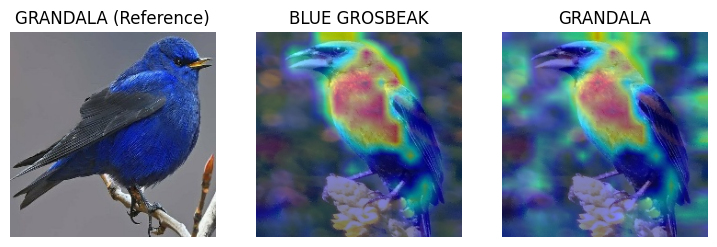

In [106]:
target_layers = [model.visual.transformer.resblocks[-1].ln_1]
cam = FinerCAM(GradCAM, model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# CAM for BLUE GROSBEAK
grayscale_cam_98, _, _, _ = cam(
    input_tensor=image_tensor,
    targets=None,
    target_idx=98,
    H=grid_h,
    W=grid_w,
    alpha=0
)

grayscale_cam_98 = grayscale_cam_98[0, :]
grayscale_cam_highres_98 = cv2.resize(grayscale_cam_98, (original_width, original_height))
cam_image_98 = show_cam_on_image(image, grayscale_cam_highres_98, use_rgb=True)

# CAM for GRANDALA 
grayscale_cam_248, _, _, _ = cam(
    input_tensor=image_tensor,
    targets=None,
    target_idx=248,
    H=grid_h,
    W=grid_w,
    alpha=0
)

grayscale_cam_248 = grayscale_cam_248[0, :]
grayscale_cam_highres_248 = cv2.resize(grayscale_cam_248, (original_width, original_height))
cam_image_248 = show_cam_on_image(image, grayscale_cam_highres_248, use_rgb=True)

grandala_ref_image = cv2.imread("imgs/GRANDALA.jpg")
grandala_ref_image = cv2.cvtColor(grandala_ref_image, cv2.COLOR_BGR2RGB) 
fig, axes = plt.subplots(1, 3, figsize=(9, 3)) 

axes[0].imshow(grandala_ref_image)
axes[0].set_title("GRANDALA (Reference)")
axes[0].axis("off")

axes[1].imshow(cam_image_98)
axes[1].set_title("BLUE GROSBEAK")
axes[1].axis("off")

axes[2].imshow(cam_image_248)
axes[2].set_title("GRANDALA")
axes[2].axis("off")

plt.show()


The blue belly is indeed an important feature, but it is not **discriminative** for distinguishing between categories.

Let's see how Finer-CAM works

In [ ]:
from pytorch_grad_cam.utils.model_targets import FinerWeightedTarget

For Finer-Target, we can specify a **main category** as an integer and a list of **comparison categories**. In this case, we compare against only one category.

In [88]:
targets = FinerWeightedTarget(main_category = 98,comparison_categories= [248], alpha =1 )

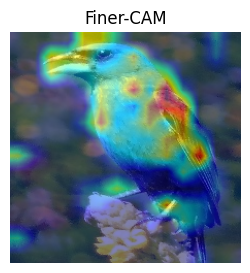

In [107]:
grayscale_cam_finer, _, _, _ = cam(
    input_tensor=image_tensor,
    targets=[targets],
    H=grid_h,
    W=grid_w,
)

grayscale_cam_finer = grayscale_cam_finer[0, :]
grayscale_cam_highres_finer = cv2.resize(grayscale_cam_finer, (original_width, original_height))
cam_image_finer = show_cam_on_image(image, grayscale_cam_highres_finer, use_rgb=True)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(cam_image_finer)
ax.set_title("Finer-CAM")
ax.axis("off")

plt.show()

Note: when target_idx and targets are not explicitly specified, FinerCAM will automatically select the highest probability category and compare it with the three most similar categories.

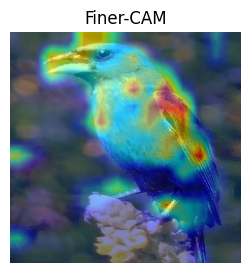

In [108]:
grayscale_cam_finer, _, _, _ = cam(
    input_tensor=image_tensor,
    targets = None,
    H=grid_h,
    W=grid_w
)

grayscale_cam_finer = grayscale_cam_finer[0, :]
grayscale_cam_highres_finer = cv2.resize(grayscale_cam_finer, (original_width, original_height))
cam_image_finer = show_cam_on_image(image, grayscale_cam_highres_finer, use_rgb=True)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(cam_image_finer)
ax.set_title("Finer-CAM")
ax.axis("off")

plt.show()